In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import seaborn as sns
from PIL import Image

In [6]:
np.random.seed(42)
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [13]:
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D

Reading the Data

In [9]:
skin_df = pd.read_csv('C:/Users/teegu/OneDrive/Documents/archive/HAM10000_metadata.csv')

In [10]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


converting the categorical data to numerical data using label Encoder

In [11]:
size = 32
le = LabelEncoder()
le.fit(skin_df['dx'])
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


new column with name as label and it is the numerical value of the class label (dx)

In [12]:
skin_df['label'] = le.transform(skin_df['dx'])
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

plots to display the count of various attributes

C:\Users\teegu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


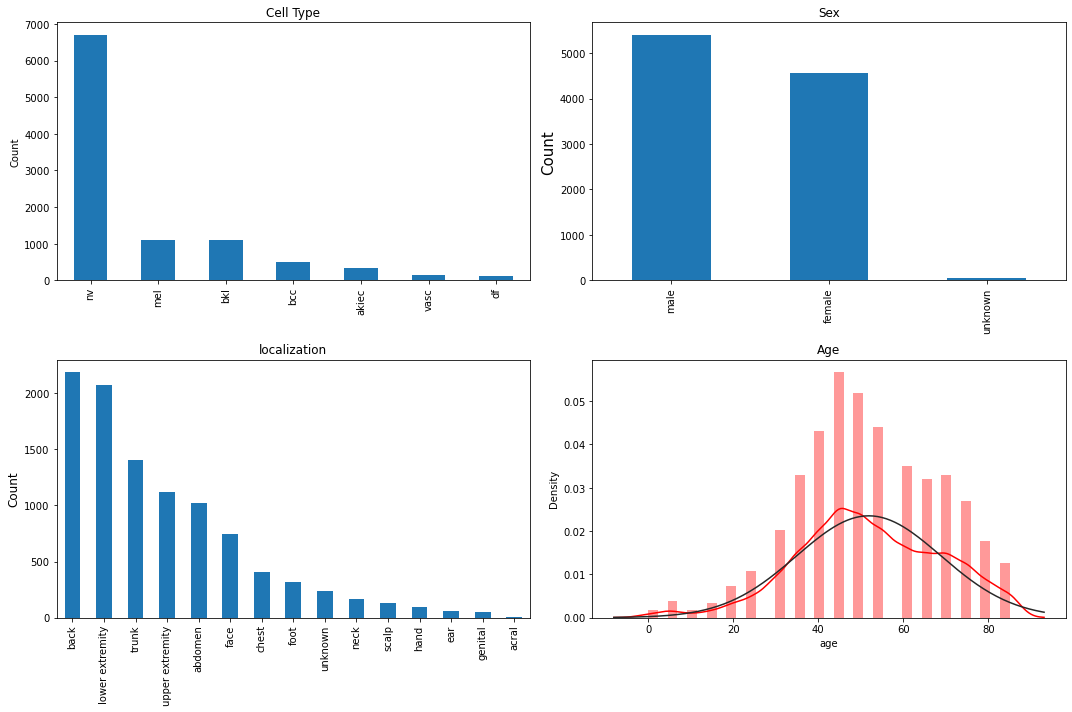

In [15]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind = 'bar',ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')


ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind = 'bar',ax=ax2)
ax2.set_ylabel('Count',size = 15)
ax2.set_title('Sex')

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind = 'bar',ax=ax3)
ax3.set_ylabel('Count',size = 12)
ax3.set_title('localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'],fit = stats.norm,color = 'red')
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [16]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


dividing the data into different dataframes for each label

In [20]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

using resample normalising the count of images in each label

In [22]:
n_samples = 500
df_0_balanced = resample(df_0,replace=True,n_samples=n_samples,random_state=42)
df_1_balanced = resample(df_1,replace=True,n_samples=n_samples,random_state=42)
df_2_balanced = resample(df_2,replace=True,n_samples=n_samples,random_state=42)
df_3_balanced = resample(df_3,replace=True,n_samples=n_samples,random_state=42)
df_4_balanced = resample(df_4,replace=True,n_samples=n_samples,random_state=42)
df_5_balanced = resample(df_5,replace=True,n_samples=n_samples,random_state=42)
df_6_balanced = resample(df_6,replace=True,n_samples=n_samples,random_state=42)

In [23]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced, df_3_balanced, df_4_balanced, df_5_balanced, df_6_balanced])
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


key-value pair key is the basename and the value is the path of the image

In [24]:
image_path = {os.path.splitext(os.path.basename(x))[0]:x
                 for x in glob(os.path.join('C:/Users/teegu/OneDrive/Documents/archive/','*','*.jpg'))}

new column for image path

In [25]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

new column which stores the image array values

In [27]:
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((size,size))))

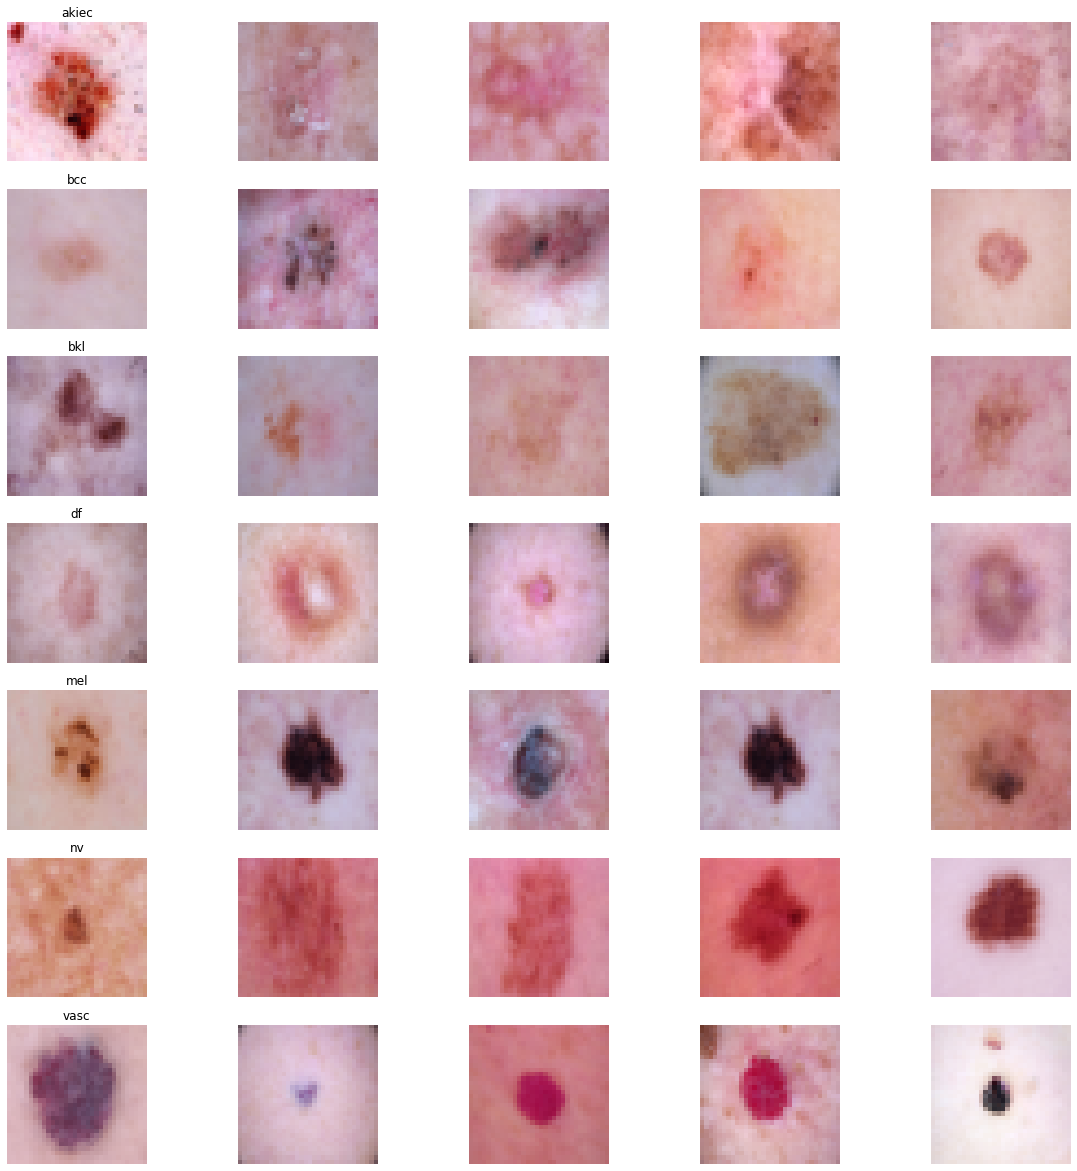

In [30]:
n_samples = 5
fig, m_axs = plt.subplots(7,n_samples,figsize = (4*n_samples,3*7))
for n_axs ,(type_name,type_rows) in  zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_,c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
        

spliting the data 

In [31]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  
Y=skin_df_balanced['label'] 
Y_cat = to_categorical(Y, num_classes=7) 
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [33]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(size, size, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)        

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [35]:
batch_size = 16 
epochs = 50

In [36]:
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
165/165 - 30s - loss: 1.8862 - acc: 0.1867 - val_loss: 1.8314 - val_acc: 0.2240 - 30s/epoch - 183ms/step
Epoch 2/50
165/165 - 18s - loss: 1.7522 - acc: 0.2610 - val_loss: 1.7028 - val_acc: 0.2766 - 18s/epoch - 107ms/step
Epoch 3/50
165/165 - 17s - loss: 1.6134 - acc: 0.3364 - val_loss: 1.6397 - val_acc: 0.3417 - 17s/epoch - 103ms/step
Epoch 4/50
165/165 - 17s - loss: 1.5012 - acc: 0.3882 - val_loss: 1.4430 - val_acc: 0.4069 - 17s/epoch - 101ms/step
Epoch 5/50
165/165 - 16s - loss: 1.4162 - acc: 0.4392 - val_loss: 1.4010 - val_acc: 0.4411 - 16s/epoch - 100ms/step
Epoch 6/50
165/165 - 16s - loss: 1.3793 - acc: 0.4484 - val_loss: 1.3220 - val_acc: 0.4491 - 16s/epoch - 100ms/step
Epoch 7/50
165/165 - 16s - loss: 1.3220 - acc: 0.4823 - val_loss: 1.3269 - val_acc: 0.4560 - 16s/epoch - 99ms/step
Epoch 8/50
165/165 - 16s - loss: 1.2793 - acc: 0.5010 - val_loss: 1.2803 - val_acc: 0.5063 - 16s/epoch - 98ms/step
Epoch 9/50
165/165 - 17s - loss: 1.2280 - acc: 0.5208 - val_loss: 1.2595 -

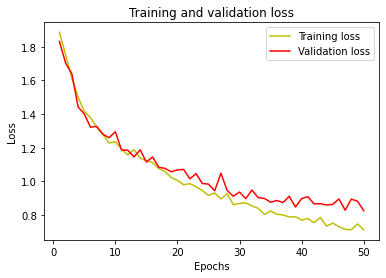

In [37]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

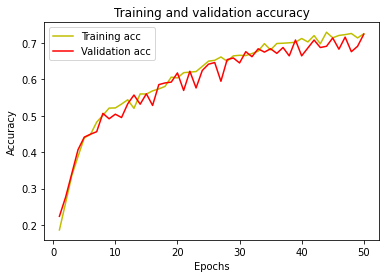

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

28/28 [==============================] - 6s 55ms/step


<AxesSubplot:>

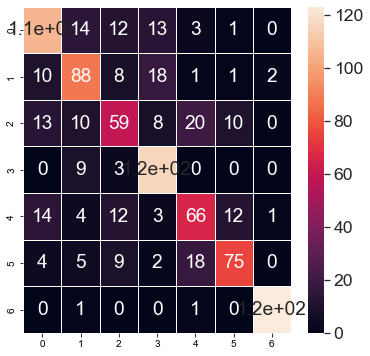

In [39]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

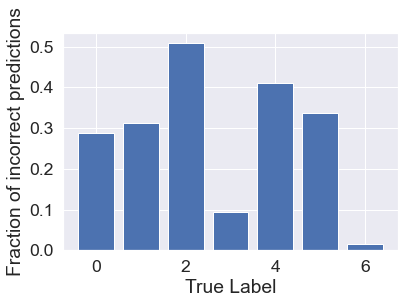

In [40]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')